# Household Behavior over the Life Cycle. Exam 2023.
## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from DynamicSpecializationModel_post import DynamicSpecializationModelClass

## Question 1
Couples in this model face several trade-offs. They face a trade-off utility of consumption and leisure (not working) today: Working today gives higher consumption but reduces leisure time. There is also an inter-temporal dimension to this trade-off since working today increases future human capital and thus future wages. Increased future wages leads to increased potential consumption in the future.

Couples also trade-off working in home production and working in the labor market. Home production (like market work) gives instantaneous utility but only market work increases human capital. Therefore, couples take into account when allocating time to home production and market work that only market work increases future consumption potential through the human capital process.

Finally, couples allocate time used on different activities across household members. They do so through both members relative comparative advantage between market work and home production. 

## Question 2
The model is solved using **backwards induction** starting with the **terminal period** which we know the value function is
$$
V_T(K_{f,T},K_{m,T})=\max_{l_{f,T},h_{f,T},l_{m,T},h_{m,T}}U(T_{f,T},T_{m,T},Q_{T}).
$$
We solve this on a **grid of human capital** values $\overrightarrow{K}\times\overrightarrow{K}$, one for each household member. This gives a 2-dimensional array of points at which this value function is known in the last period of life.

We can then **iterate backwards in time and interpolate** the next-period value function using e.g. 2-dimensional linear interplation. In the second-to-last period, we then solve for optimal  labor market work and home production of each household member on the same $\overrightarrow{K}\times\overrightarrow{K}$ grid 
$$
V_{T-1}(K_{f,T-1},K_{m,T-1})=\max_{l_{f,T-1},h_{f,T-1},l_{m,T-1},h_{m,T-1}}U(T_{f,T-1},T_{m,T-1},Q_{t}) + \beta \check{V_T}((K_{f,T},K_{m,T})).
$$ 
where $\check{V_T}(K_{f,T},K_{m,T})$ denotes 2-dimensional interpolation. We continue this process until the first period of life.

The maximization step is performed using a **numerical solver**. Because all hours has to be less than 24 a day, we pass that as bounds to the optimizer. We also need to handle that the sum of hours spend on home production and market work cannot exceed 24 hours, $T_{j,t}=l_{j,t}+h_{j,t} \leq24$ $j\in\{f,m\}$. This leads to two linear inequality constraints which we could pass on to the solver. The implementation here uses a penalization approach instead (see `model.clip_and_penalty`).

## Question 3
See answer to question 7 below.

## Question 4

In [3]:
# solve and simulate baseline model
model = DynamicSpecializationModelClass(par={'prob_birth':0.0})
%time model.solve()
%time model.simulate()

CPU times: user 1.3 s, sys: 19.5 ms, total: 1.32 s
Wall time: 1.56 s
CPU times: user 533 ms, sys: 4.97 ms, total: 538 ms
Wall time: 546 ms


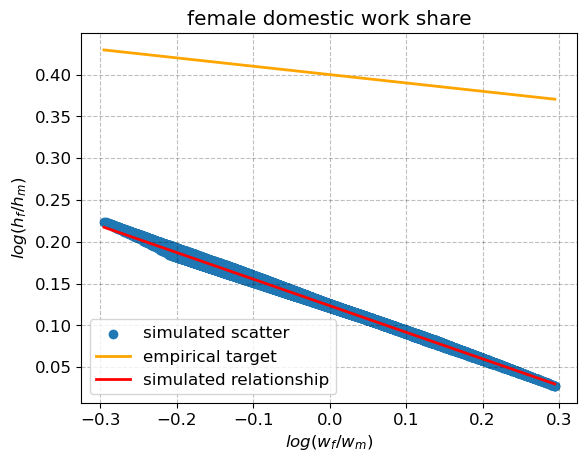

In [4]:
# plot the relationship between wages and hours in home production
model.plot()

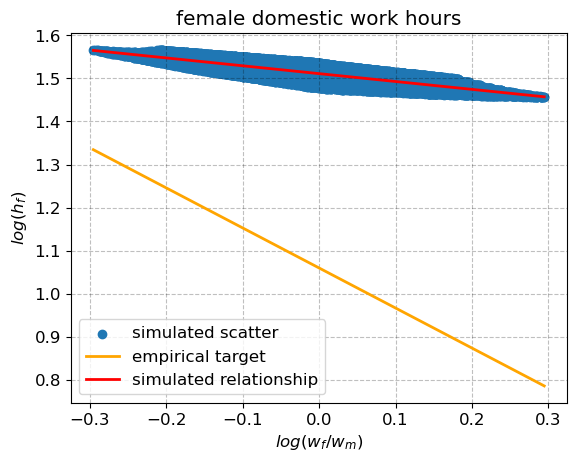

In [5]:
model.plot_female_hours()

The link between $\log(h_{i,f,t}/h_{i,m,t})$ and $\log(w_{i,f,t}/w_{i,m,t})$ looks to be slightly different in the simulation than in the empirical target from [Siminski and Yetsenga (2022)](https://www.journals.uchicago.edu/doi/full/10.1086/718430). Especially the intercept looks to be too low in the simulation, while the slope is actually a bit steeper. This suggests that, in the model, when men and women have the same wage rates, women and men share the time in home production more equal than observed in the data. 

A weak link between $\log(h_{i,f,t}/h_{i,m,t})$ and $\log(w_{i,f,t}/w_{i,m,t})$ through a low (in abosulte terms) $\hat{\beta}_1$ suggests that the share of home production hours is not greatly influenced by the absolute advantage in market work. 

## Question 5
The recursive formulation
of the model is for $t<T$:
$$
\begin{align}
V_{t}(n_t,K_{f,t},K_{m,t}) & =\max_{l_{f,t},h_{f,t},l_{m,t},h_{m,t}}U(T_{f,t},T_{m,t},Q_{t})+\beta \mathbb{E}_t[V_{t+1}(n_{t+1},K_{f,t+1},K_{m,t+1})]\\
 & \text{s.t.}\\
C_{t} & =w_{f,t}l_{f,t}+w_{m,t}l_{m,t}+X_{t}\\
H_{t} & =\left(\alpha h_{f,t}^{\frac{\sigma-1}{\sigma}}+(1-\alpha)h_{m,t}^{\frac{\sigma-1}{\sigma}}\right)^{\frac{\sigma}{\sigma-1}}\\
Q_{t} & =C_{t}^{\omega(n_t)}H_{t}^{1-\omega(n_t)}\\
\log w_{j,t} & =\gamma_{j,0}+\gamma_{j,1}K_{j,t},\:j\in\{f,m\}\\
K_{j,t+1} & =(1-\delta)K_{j,t}+l_{j,t}/24,\:j\in\{f,m\}\\
n_{t+1} & = \begin{cases}
\begin{array}{ll}
n_t+1 & \text{with prob. } p_{t+1}(n_{t})\\
n_t & \text{with prob. } 1-p_{t+1}(n_{t}).
\end{array}\end{cases} \\
T_{j,t} & =l_{j,t}+h_{j,t},\:j\in\{f,m\}\\
l_{j,t},h_{j,t} & \geq0,\:j\in\{f,m\}\\
T_{j,t} & \leq24,\:j\in\{f,m\}
\end{align}
$$
where $\omega(n_{t})=\omega+\omega_{n}n_{t}$ and the birth probability is
$$
p_{t+1}(n_{t})=\begin{cases}
\begin{array}{ll}
0.1 & \text{if }n_{t}=0\\
0.0 & \text{else}.
\end{array}\end{cases}
$$

The **expected value** thus is
$$
\begin{align}
\mathbb{E}_t[V_{t+1}(n_{t+1},K_{f,t+1},K_{m,t+1})] &= p_{t+1}(n_{t})V_{t+1}(n_{t}+1,K_{f,t+1},K_{m,t+1}) \\
 & + (1-p_{t+1}(n_{t}))V_{t+1}(n_{t},K_{f,t+1},K_{m,t+1}) 
\end{align}
$$

## Question 6
The interpretation of a negative $\omega_n$ is that the presence of a child increases the weight that the household puts on home production. In turn, time allocated to those activities has a higher value when children are present.

## Question 7

In [6]:
# solve baseline and extended model
specs = {
    'model 1':{'prob_birth':0.0},
    'model 2':{'prob_birth':0.1},
}

models = dict()
for name,spec in specs.items():
    models[name] = DynamicSpecializationModelClass()
    
    for par_name,val in spec.items():
        setattr(models[name].par,par_name,val)

    models[name].solve()
    models[name].simulate()

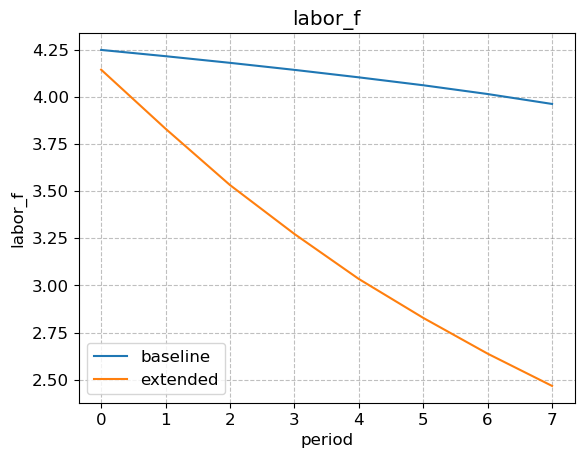

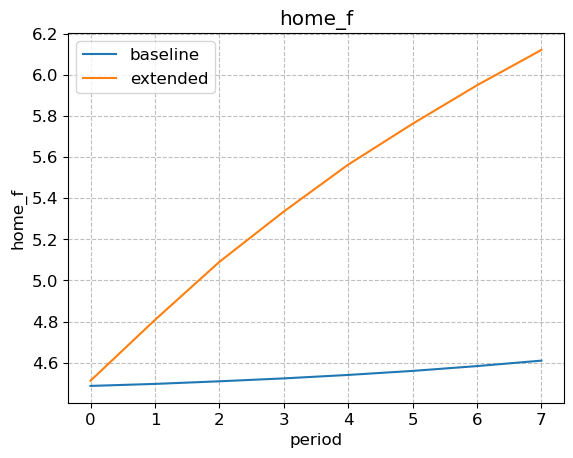

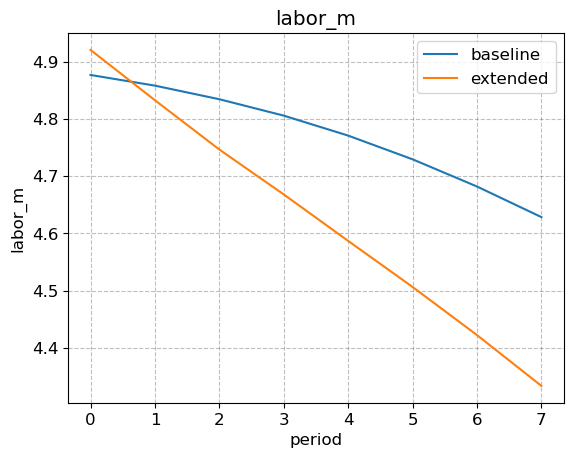

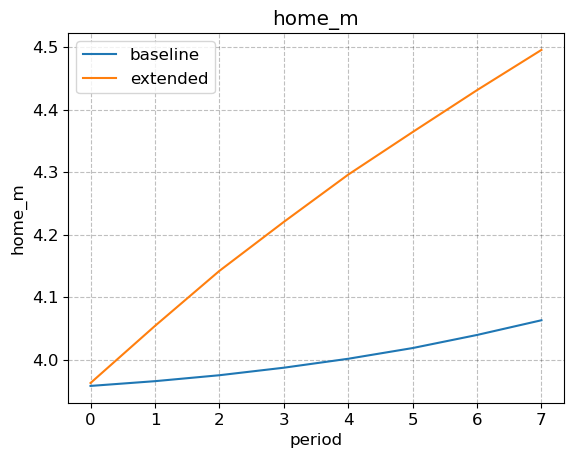

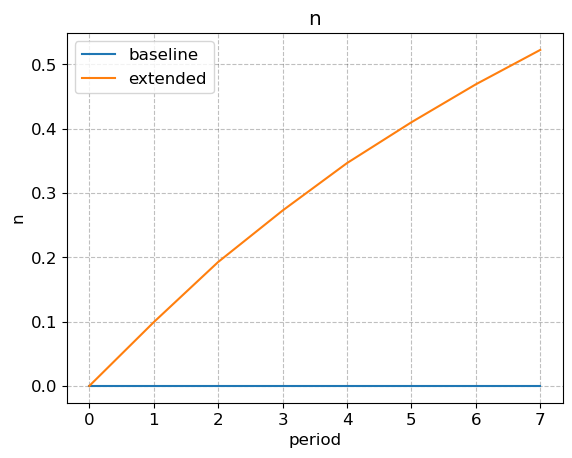

In [7]:
# Plot age profiles in both
for outcome in ('labor_f','home_f','labor_m','home_m','n'):
    fig, ax = plt.subplots()
    outcome_base = np.mean(getattr(models['model 1'].sim,outcome),axis=0)
    outcome_alt = np.mean(getattr(models['model 2'].sim,outcome),axis=0)
    ax.plot(outcome_base,label='baseline')
    ax.plot(outcome_alt,label='extended')
    ax.set(title=outcome,xlabel='period',ylabel=outcome);
    ax.legend()

## Question 8

In [8]:
# the model is from now on the extended version
model = models['model 2'].copy()

In [9]:
def calculate_event_mean(model,outcome_str,min_time=-5,max_time=5,relative=-1,pct=True):
    ''' calculate average outcome across time since birth '''

    par = model.par
    sim = model.sim

    # time since birth
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # event-study mean
    outcome = getattr(sim,outcome_str)
    event_grid = np.arange(min_time,max_time+1)

    event_outcome = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth==time])

    # relative to period before birth
    if relative is not None:
        event_outcome_rel = event_outcome - event_outcome[event_grid==relative]
        if pct:
            event_outcome = event_outcome_rel/event_outcome[event_grid==relative]
        else:
            event_outcome = event_outcome_rel

    # return the indicators of distance to event along with the average outcome for each time periode            
    return event_grid,event_outcome

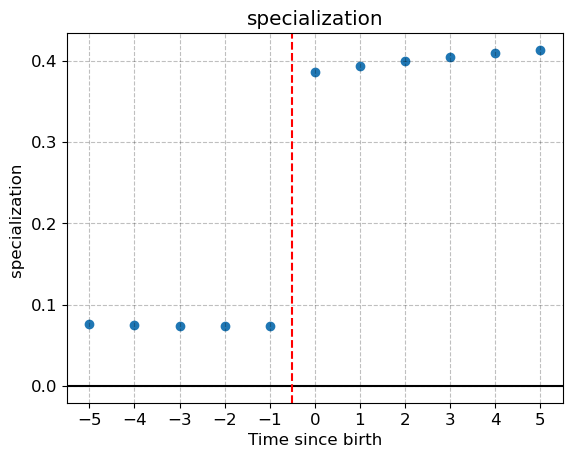

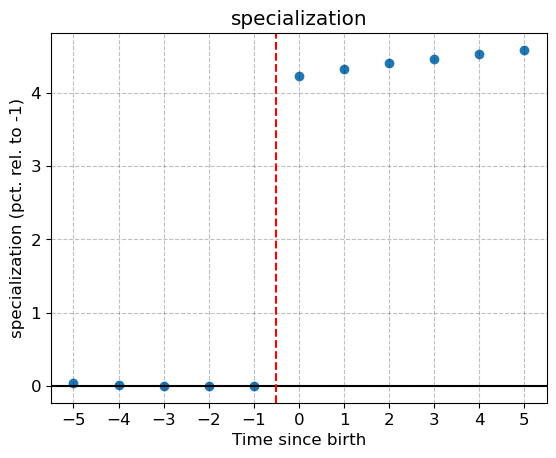

In [10]:
for relative in (None,-1):
    for val in ('specialization',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

## Question 9

In [39]:
# data moments

moms_data = np.array([0.4,-0.1,1.012,0.009,1.106,-0.093,1.0,0.0,-0.40])

In [41]:
# objective function
def calc_moments(model):
    # a. female/male share regression coefficients
    constant_share,slope_share = model.regress()

    # b. male labour supply regressions coefficients
    constant_m, slope_m = model.regress_male()

    #c. female labour supply regression coefficients
    constant_f, slope_f = model.regress_female()

    # b. specialisation event study effect
    _,event_rel = calculate_event_mean(model,'specialization',min_time=-2,max_time=0,relative=-1,pct=True)
    event_spec = event_rel[-1]

    # c. male labour supply event study effect
    _,event_rel = calculate_event_mean(model,'labor_m',min_time=-2,max_time=0,relative=-1,pct=True)
    event_labor_m = event_rel[-1]

    # d. female labour supply event study effect
    _,event_rel = calculate_event_mean(model,'labor_f',min_time=-2,max_time=0,relative=-1,pct=True)
    event_labor_f = event_rel[-1]

    # . combine moments
    return np.array([constant_share,slope_share,constant_m,slope_m,constant_f,slope_f,event_spec,event_labor_m,event_labor_f])

# equal weighting (although the weigting matrix does not matter since #moments=#parameters)
def obj(theta,theta_names,model,moms_data,do_print=False):
    
    # a. update parameters
    for i,name in enumerate(theta_names):
        setattr(model.par,name,theta[i])

    # b. solve and simulate model
    model.solve()
    model.simulate()

    # c. calcualte moment differences
    moms_sim = calc_moments(model)
    diff = moms_sim - moms_data
    sqsum = np.sum(diff*diff)

    # d. print
    if do_print: 
        [print(f'{name}:{theta[i]:2.3f} ',end='') for i,name in enumerate(theta_names)]
        print(f'-> sqsum={sqsum:2.8f}',end="\r")
    
    # e. return squared difference
    return sqsum

In [43]:
# set parameters and initial values
theta_names = ('alpha','alpha_n','sigma','omega_n','epsilon_f','epsilon_m','wage_humcap_f','wage_humcap_m','nu')
theta_init = np.array([0.9,0.05,0.1,-0.25, 1.1,0.9,0.1,0.05,0.01])

obj_init = obj(theta_init,theta_names,model,moms_data,do_print=True)

In [44]:
print(moms_data)

[ 0.4   -0.1    1.012  0.009  1.106 -0.093  1.     0.    -0.4  ]


In [45]:
# estimate using a numerical solver
obj_func = lambda theta: obj(theta,theta_names,model,moms_data,do_print=True)

est = minimize(obj_func,theta_init,method='nelder-mead')

/Users/joshuaclyne/Library/Mobile Documents/com~apple~CloudDocs/2024/Autumn Semester/Public Economics Seminar/Seminar project code/DynamicSpecializationModel_post.py:311: RuntimeWarning: invalid value encountered in divide
  sim.specialization = sim.home_f/(sim.home_f+sim.home_m)-sim.labor_f/(sim.labor_f+sim.labor_m)


Output from latest attempt:
alpha:0.954 alpha_n:0.026 sigma:0.109 omega_n:-0.102 epsilon_f:1.773 epsilon_m:1.666 wage_humcap_f:0.093 wage_humcap_m:0.076 nu:0.008 -> sqsum=0.06208415

## Question 10

namespace(T=8, beta=0.98, rho=2.0, nu=0.00759744069865631, epsilon_f=1.7727186133971025, epsilon_m=1.6657337953684332, omega=0.5, omega_n=-0.1024429248046947, alpha=0.9538350825960824, alpha_n=0.02593215213257964, sigma=0.1090424063134012, sigma_n=0.0, wage_const_f=0.0, wage_humcap_f=0.09303232707065678, wage_const_m=0.0, wage_humcap_m=0.07590626670890005, X=0.0, delta=0.1, prob_birth=0.1, num_n=2, num_K=10, max_K=15.0, simT=8, simN=10000, grid_K=array([ 0.        ,  1.3379026 ,  2.72503652,  4.16852182,  5.67763341,
        7.26493398,  8.9483755 , 10.75571022, 12.73574142, 15.        ]), grid_n=array([0, 1]))


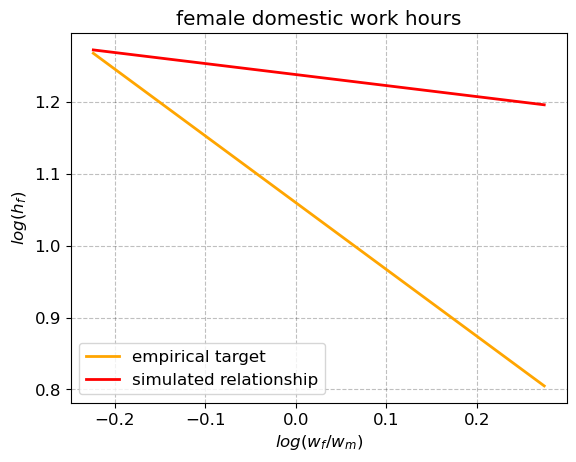

In [52]:
print(model.par)
model.plot_female_hours()

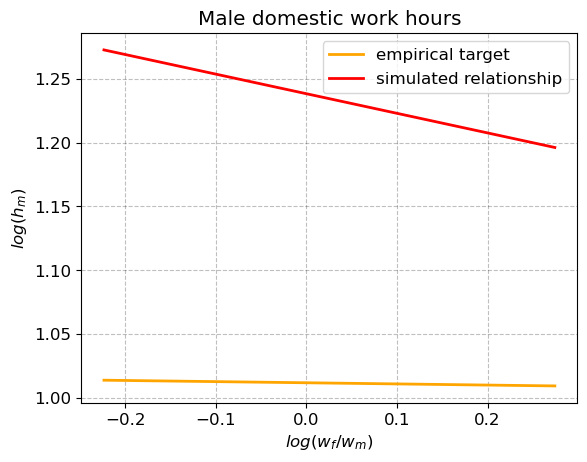

In [57]:
model.plot_male_hours()

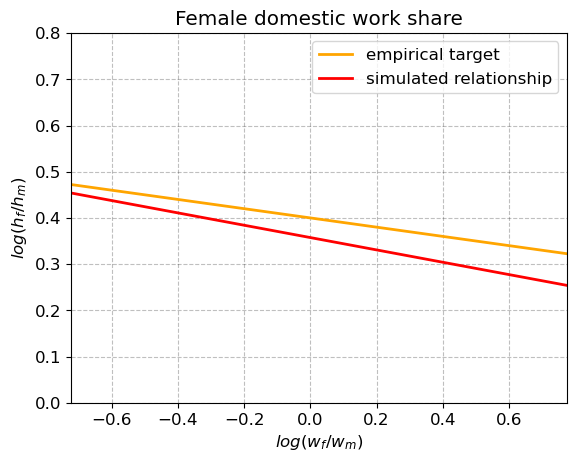

In [56]:
model.plot()

NameError: name 'x' is not defined

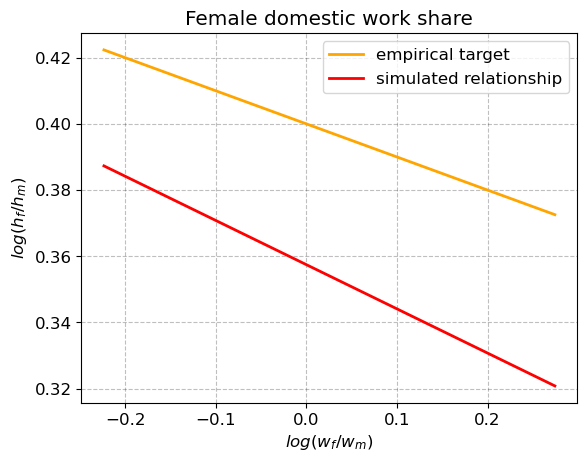

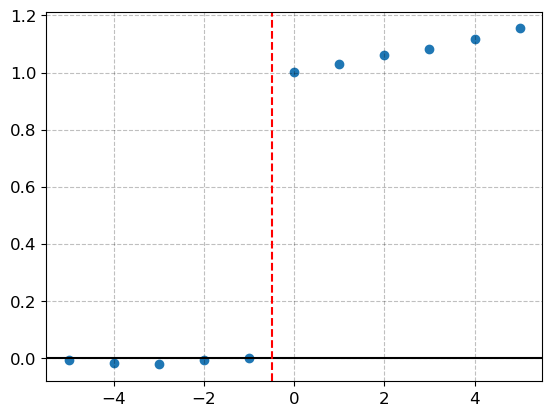

In [50]:
# since the model-object already has the estimated parameters updated, we can now plot the model fit
model.plot()

for val in ('specialization',):
        
    event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=-1,pct=True)

    fig, ax = plt.subplots()
    ax.scatter(event_grid,event_rel)
    ax.axhline(y=0,color='black')
    ax.axvline(x=-0.5,color='red',linestyle='dashed')
    ax.axhline(y=1  if x>-0.5 else None,color='orange')
    ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} (pct. rel. to -1)',xticks=event_grid);

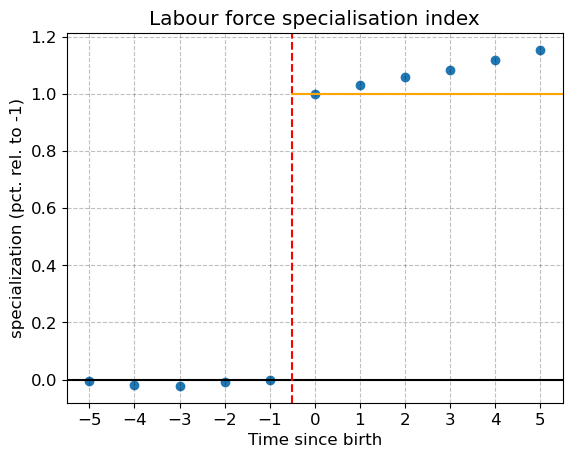

In [59]:
fig, ax = plt.subplots()
ax.scatter(event_grid, event_rel)
ax.axhline(y=0, color='black')
ax.axvline(x=-0.5, color='red', linestyle='dashed')

# Plot the orange line only when the x-axis value is greater than -0.5
# We'll check where event_grid is greater than -0.5 and limit the axhline accordingly

if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))

ax.set(title='Labour force specialisation index', xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)



plt.show()


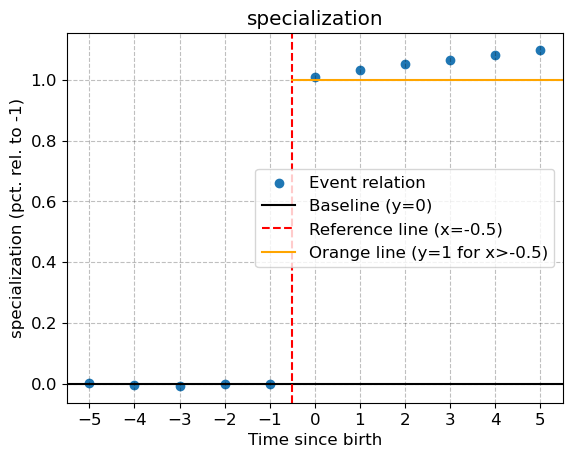

In [23]:
fig, ax = plt.subplots()

# Scatter plot for the event-related data
ax.scatter(event_grid, event_rel, label='Event relation')
ax.axhline(y=0, color='black', label='Baseline (y=0)')
ax.axvline(x=-0.5, color='red', linestyle='dashed', label='Reference line (x=-0.5)')

# Plot the orange line only when the x-axis value is greater than -0.5
if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid), label='Orange line (y=1 for x>-0.5)')

# Set title, labels, and ticks
ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)

# Show the legend
ax.legend()

plt.show()


## Question 11

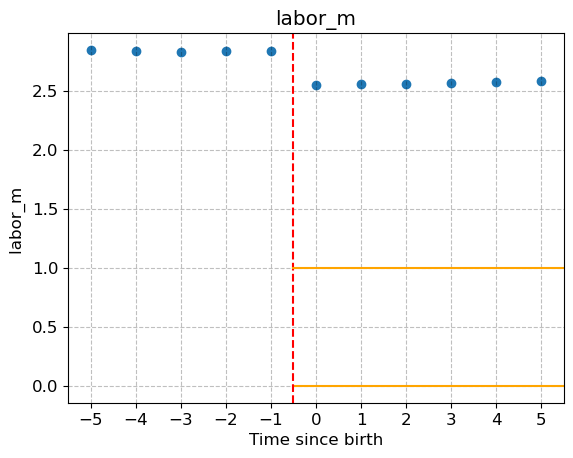

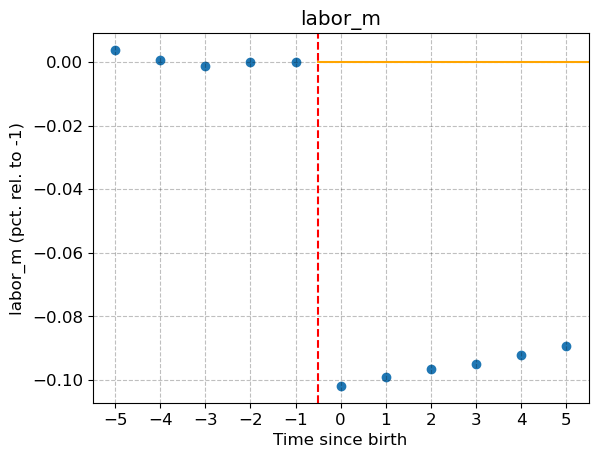

In [63]:
for relative in (None,-1):
    for val in ('labor_m',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        
        if any(event_grid > -0.5):
            ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        if any(event_grid > -0.5):
            ax.axhline(y=0.0, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        #ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

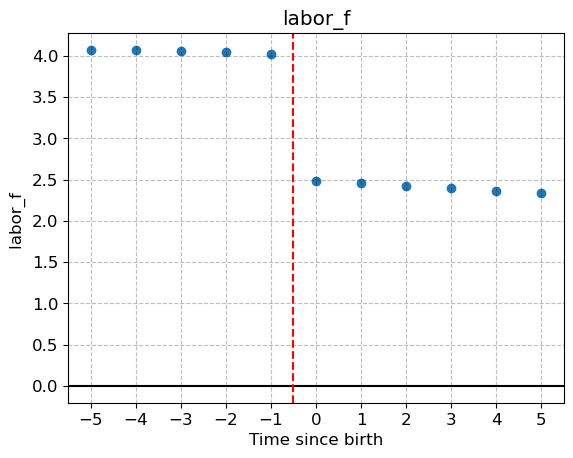

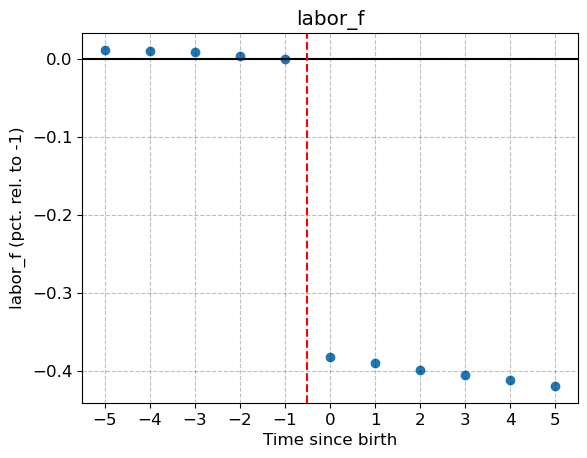

In [ ]:
for relative in (None,-1):
    for val in ('labor_f',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

In the model, men reduce their labor market hours around childbirth. This is in contrast to what we see in exitsing literature, e.g. [Kleven et al. (2019)](https://www.aeaweb.org/articles?id=10.1257/app.20180010) in which we see hardly any response in labor market behavior of men around childbirth.

There are several ways in which we could let parameters of the model depend on children in order to fit this pattern too. We could e.g. let the absolute advantage of home production depend on children though $\alpha(n_t)=\alpha+\alpha_nn_t$ and/or we could let the curvature of the dis-utility of work depend on children differentially between men and women, `$\epsilon_j(n_t)=\epsilon_{j}+\epsilon_{j,n}n_t$.

## Question 12

In [ ]:
# calculate slope coefficient for several values of human capital depreciation
model_gamma = model.copy() 

grid_gamma = np.linspace(0.1,1.0,5)
grid_slope = np.nan + np.ones(grid_gamma.shape)
for i_gamma,gamma in enumerate(grid_gamma):
    # a. set depreciation parameter
    model_gamma.par.wage_humcap_f = gamma
    model_gamma.par.wage_humcap_m = gamma

    # b. solve and simulate
    model_gamma.solve()
    model_gamma.simulate()

    # c. run regression
    _, grid_slope[i_gamma] = model_gamma.regress()

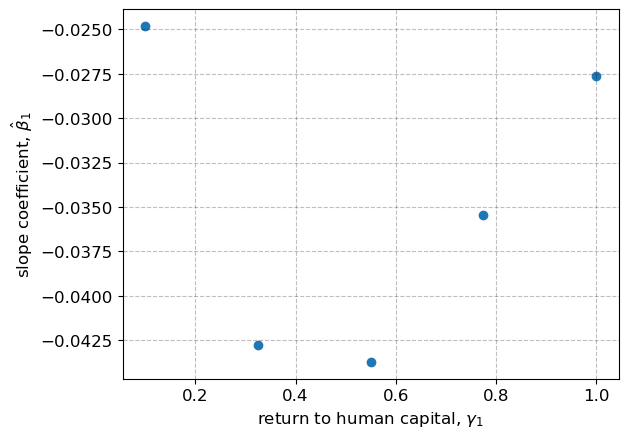

In [ ]:
fig,ax = plt.subplots()
ax.scatter(grid_gamma,grid_slope)
ax.set(xlabel=r'return to human capital, $\gamma_1$',ylabel=r'slope coefficient, $\hat{\beta}_1$');

## Question 13
The question asks for a grid of $\sigma_w$ in the interval 0-1, but for large values of measurement error, wages can turn negative. Taking logs will thus not work in the regression. Removing negative values or focusing on a more narrow interval ($\sigma_w>0.2$ seems to give problems) is fine.

In [ ]:
# add measurement error to simulation only
grid_sigma = np.linspace(0.0,0.2,5)
grid_slope2 = np.nan + np.ones(grid_sigma.shape)

# set seed to ensure the same outcome every time
np.random.seed(1353)
for i_sigma,sigma in enumerate(grid_sigma):
    # a. draw normal measurement error
    eps_f = sigma*np.random.normal(0,1,size=model.sim.wage_f.shape)
    eps_m = sigma*np.random.normal(0,1,size=model.sim.wage_f.shape)

    # b. add to copy of simulated wages in baseline model. Does not change anything else in solution or simulation. 
    # If i changed e.g. wage_f in the simulation module, that would lead to changed wages for women and they would react to that.
    model_sigma = model.copy()
    model_sigma.sim.wage_f += eps_f
    model_sigma.sim.wage_m += eps_m

    # c. run regression
    _, grid_slope2[i_sigma] = model_sigma.regress()

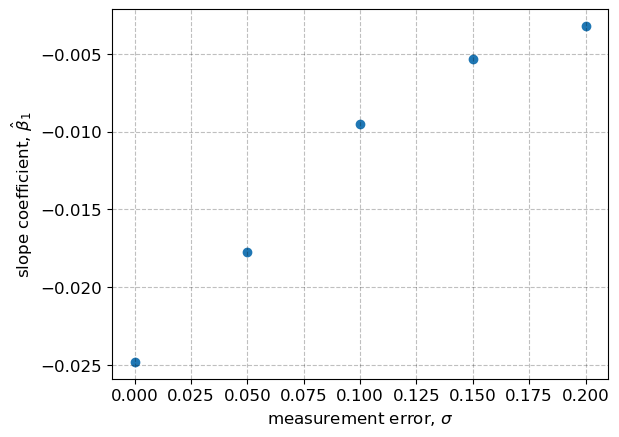

In [ ]:
fig,ax = plt.subplots()
ax.scatter(grid_sigma,grid_slope2)
ax.set(xlabel=r'measurement error, $\sigma$',ylabel=r'slope coefficient, $\hat{\beta}_1$');